In [650]:
import os
import json
import pandas as pd
import numpy as np

from os.path import exists

In [651]:
def IssuerCode(state=False):
    issuers = pd.read_csv('data/s&p500.csv',sep=';')
    issuer_filtered = []
    for code_stock in issuers.Ticker:
        # Check last transaction 2023
        # Have 200 transaction
        path = f'data/transactions/{code_stock}.csv'
        if os.path.exists(path):
            historical = pd.read_csv(path)
            last_date_row = historical.Date.iloc[len(historical)-1] # get last date transactions
            data_test = historical[-1000:]['Close'] # get data test
            var = np.var(data_test) # calculate variance from data test
            if (last_date_row[:4] == '2023' and len(historical) >= 200 and var > 0):
                issuer_filtered.append(code_stock)
    
    if state:
        print("Code of Stock Issuer: {}".format(issuer_filtered))
    else:
        return issuer_filtered

In [652]:
issuers = IssuerCode()

In [653]:
path_transaction = 'data/transactions/'

issuer_sectors = {'code':[],'len':[]}

for issuer in issuers:    
    path = f'{path_transaction}{issuer}.csv'
    if exists(path):
        historical = pd.read_csv(path)
        issuer_sectors['code'].append(issuer)
        issuer_sectors['len'].append(len(historical))

In [654]:
issuer_result = {'code':[],'lookback':[],'arch':[],'r2':[],'mse':[],'rmse':[],'mape':[],'acc':[],'f1':[]}

lookbacks = [5,10,15,20,25]
architecture = ['TFGRU', 'TFLSTM', 'TFGRULSTM', 'TFLSTMGRU']

path_result = 'results/evaluations/'

for code in issuers:
    for archi in architecture:
        for lookback in lookbacks:
            if 'GCN' in archi:
                path_score = f'{path_result}{archi}_multivariate_graph/{code}_{lookback}_test_score.json'
                path_class = f'{path_result}{archi}_multivariate_graph/{code}_{lookback}_test_classification.json'
            else:
                path_score = f'{path_result}{archi}_multivariate/{code}_{lookback}_test_score.json'
                path_class = f'{path_result}{archi}_multivariate/{code}_{lookback}_test_classification.json'
            
            score_json = json.load(open(path_score))
            class_json = json.load(open(path_class))
            
            issuer_result['code'].append(code)
            issuer_result['lookback'].append(lookback)
            issuer_result['arch'].append(archi)
            issuer_result['r2'].append(score_json['R2'])
            issuer_result['mse'].append(score_json['MSE'])
            issuer_result['rmse'].append(score_json['RMSE'])
            issuer_result['mape'].append(score_json['MAPE'])
            issuer_result['acc'].append(class_json['accuracy'])
            issuer_result['f1'].append(class_json['macro avg']['f1-score'] if 'macro avg' in class_json else 0)

In [655]:
df_result = pd.DataFrame(issuer_result)
df_averages = df_result.groupby(['code', 'arch'], as_index=False).mean()[['code','arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]

best_arch_r2 = df_averages.loc[df_averages.groupby(['code'])['r2'].idxmax()]
best_arch_mse = df_averages.loc[df_averages.groupby(['code'])['mse'].idxmin()]
best_arch_rmse = df_averages.loc[df_averages.groupby(['code'])['rmse'].idxmin()]
best_arch_mape = df_averages.loc[df_averages.groupby(['code'])['mape'].idxmin()]
best_arch_f1 = df_averages.loc[df_averages.groupby(['code'])['f1'].idxmax()]

df_best = pd.concat([best_arch_r2, best_arch_mse, best_arch_rmse, best_arch_mape, best_arch_f1])

df_best_arch = df_best.groupby(['code', 'arch'], as_index=False).count()[['code', 'arch', 'r2']]
best_arch = df_best_arch.loc[df_best_arch.groupby(['code'])['r2'].idxmax()]
best_arch = best_arch.rename(columns={'r2': 'count'})
best_arch_count = best_arch.groupby(['arch'], as_index=False).count()[['arch','count']]

        arch  count
1  TFLSTMGRU      1
0      TFGRU      9


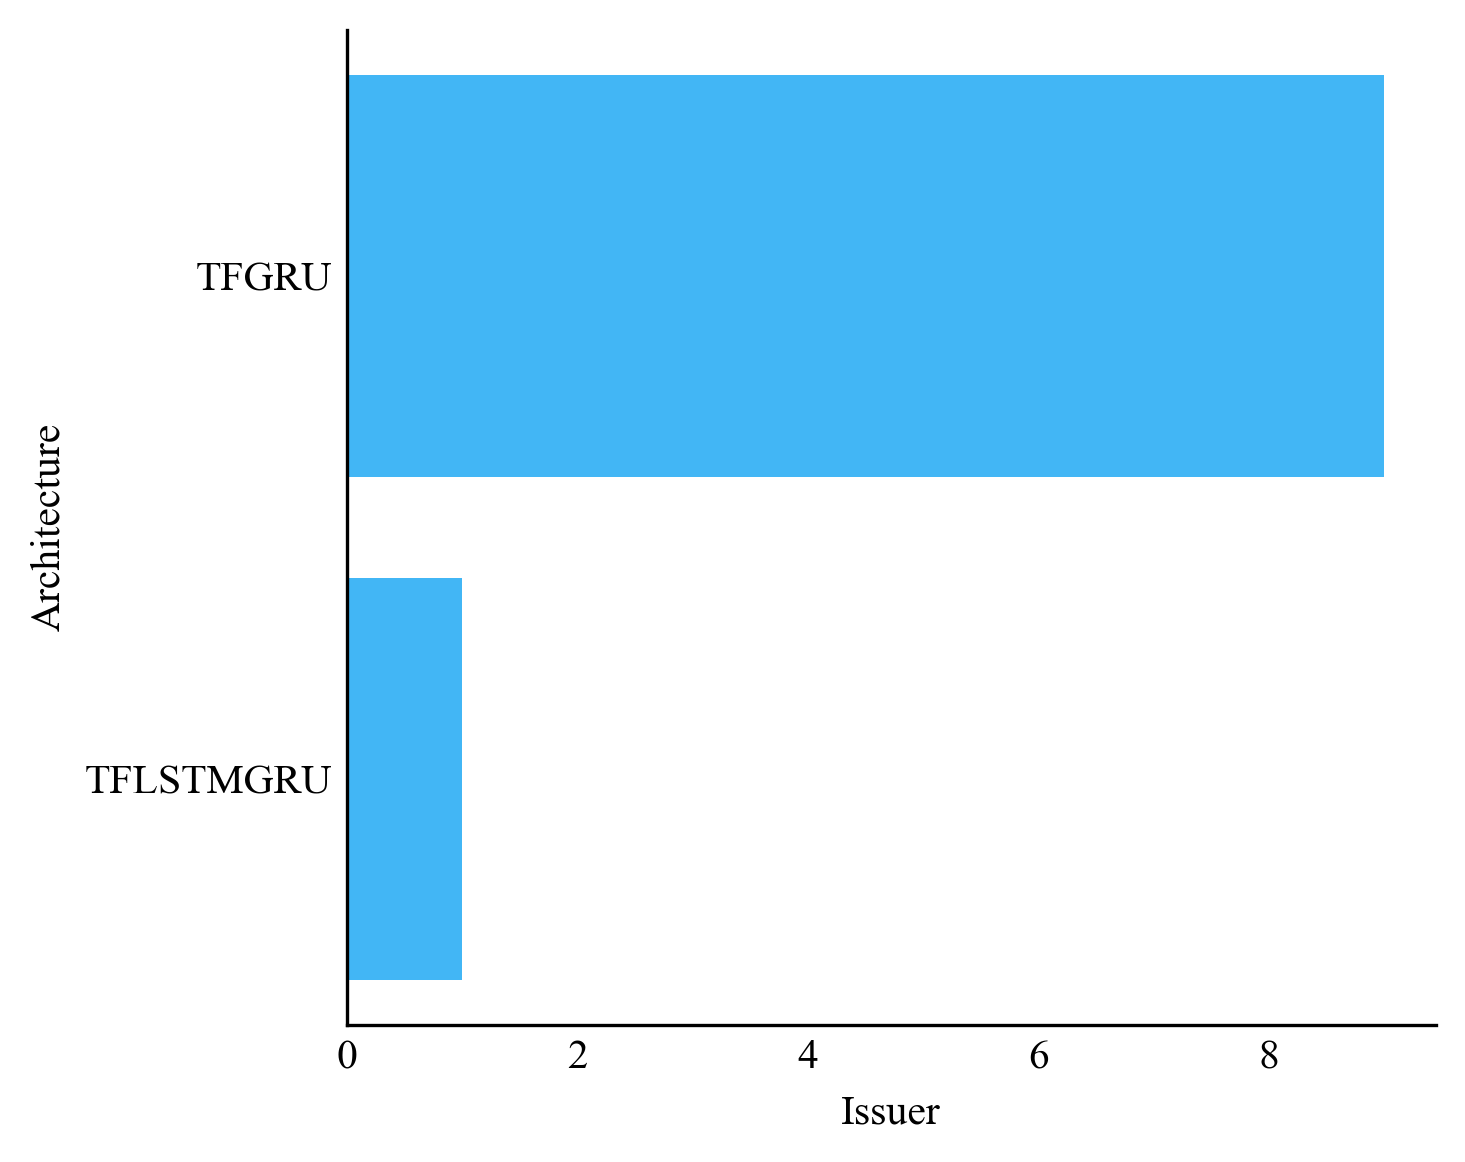

In [656]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

# bar_colors = ['#4287f5', '#42f5a3', '#f54242', '#f5d142', '#a342f5', '#f57f42', '#42b6f5', '#f542c6', '#42f5e9', '#c6f542', '#f5bc42']
df = best_arch_count.sort_values('count', ascending=True)
print(df)
plt.barh(df['arch'], df['count'], color='#42b6f5')
plt.xlabel('Issuer')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

In [657]:
df_result = pd.DataFrame(issuer_result)
df_averages = df_result.groupby(['code', 'arch', 'lookback'], as_index=False).mean()[['code','arch','lookback','r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]

best_lookback_r2 = df_averages.loc[df_averages.groupby(['code'])['r2'].idxmax()]
best_lookback_mse = df_averages.loc[df_averages.groupby(['code'])['mse'].idxmin()]
best_lookback_rmse = df_averages.loc[df_averages.groupby(['code'])['rmse'].idxmin()]
best_lookback_mape = df_averages.loc[df_averages.groupby(['code'])['mape'].idxmin()]
best_lookback_f1 = df_averages.loc[df_averages.groupby(['code'])['f1'].idxmax()]

df_best = pd.concat([best_lookback_r2, best_lookback_mse, best_lookback_rmse, best_lookback_mape, best_lookback_f1])

df_best_lookback = df_best.groupby(['code', 'arch', 'lookback'], as_index=False).count()[['code', 'arch', 'lookback', 'r2']]
best_lookback = df_best_lookback.loc[df_best_lookback.groupby(['code'])['r2'].idxmax()]
best_lookback = best_lookback.rename(columns={'r2': 'count'})
best_lookback_count = best_lookback.groupby(['arch', 'lookback'], as_index=False).count()[['arch','lookback','count']]

    arch  lookback  count
0  TFGRU        10      1
1  TFGRU        15      2
3  TFGRU        25      3
2  TFGRU        20      4


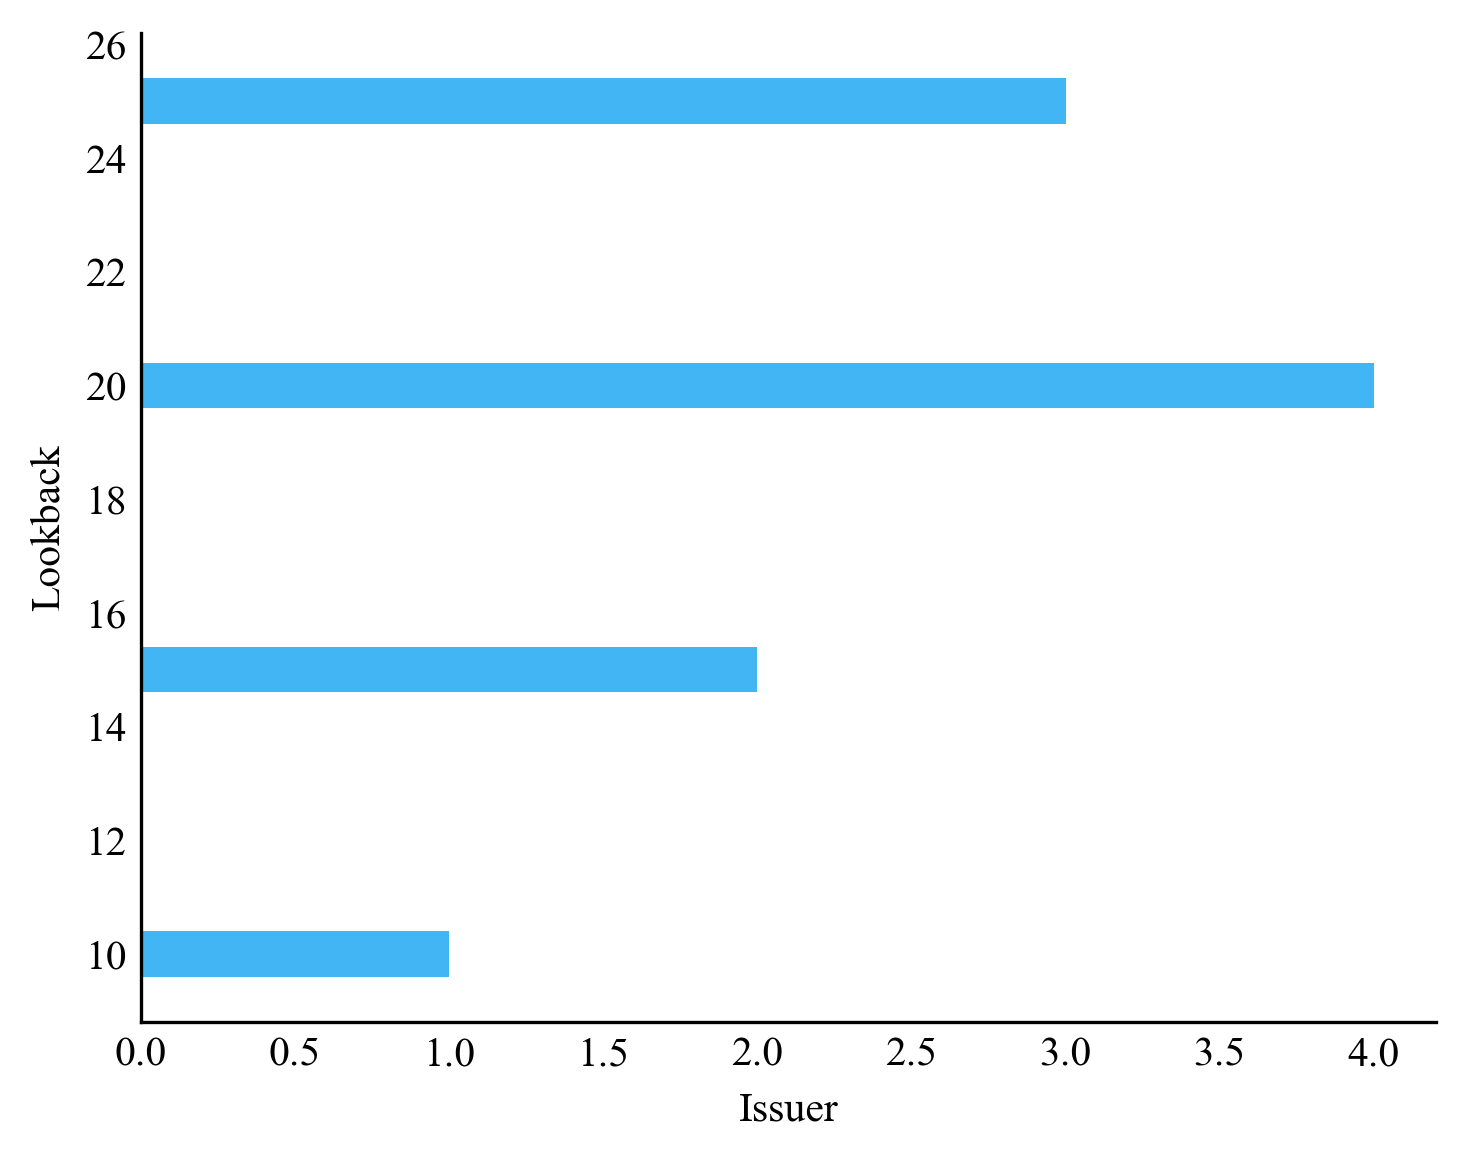

In [658]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

# bar_colors = ['#4287f5', '#42f5a3', '#f54242', '#f5d142', '#a342f5', '#f57f42', '#42b6f5', '#f542c6', '#42f5e9', '#c6f542', '#f5bc42']
df = best_lookback_count.sort_values('count', ascending=True)
print(df)
plt.barh(df['lookback'], df['count'], color='#42b6f5')
plt.xlabel('Issuer')
plt.ylabel('Lookback')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

In [659]:
df_result = pd.DataFrame(issuer_result)

df_averages_score = df_result[['lookback', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']].groupby(['lookback'], as_index=False).mean()[['lookback', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
df_averages_score.to_excel('df_averages_lookback_score.xlsx', index=False)

In [660]:
df_result = pd.DataFrame(issuer_result)

df_averages_score = df_result[['arch', 'lookback', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']].groupby(['arch', 'lookback'], as_index=False).mean()[['arch', 'lookback', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
df_averages_score.to_excel('df_averages_score.xlsx', index=False)

In [661]:
df_result = pd.DataFrame(issuer_result)

# df_averages_score = df_result.groupby(['arch'], as_index=False).mean()[['arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
df_averages_score = df_result[['arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']].groupby(['arch'], as_index=False).mean()[['arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
# df_averages_score = df_result[['arch', 'r2', 'mse', 'rmse', 'mape', 'acc', 'f1']]
df_averages_score.to_excel('df_averages_arch_score.xlsx', index=False)

        arch        r2          mse       rmse      mape       acc        f1
3  TFLSTMGRU  0.788476  1848.678099  24.969440  0.093744  0.503283  0.453904
1  TFGRULSTM  0.804831  1700.646970  24.004702  0.091062  0.503944  0.459109
2     TFLSTM  0.808040  1699.309871  23.901767  0.090257  0.502523  0.445102
0      TFGRU  0.924304   634.638006  14.703255  0.056229  0.505766  0.453773


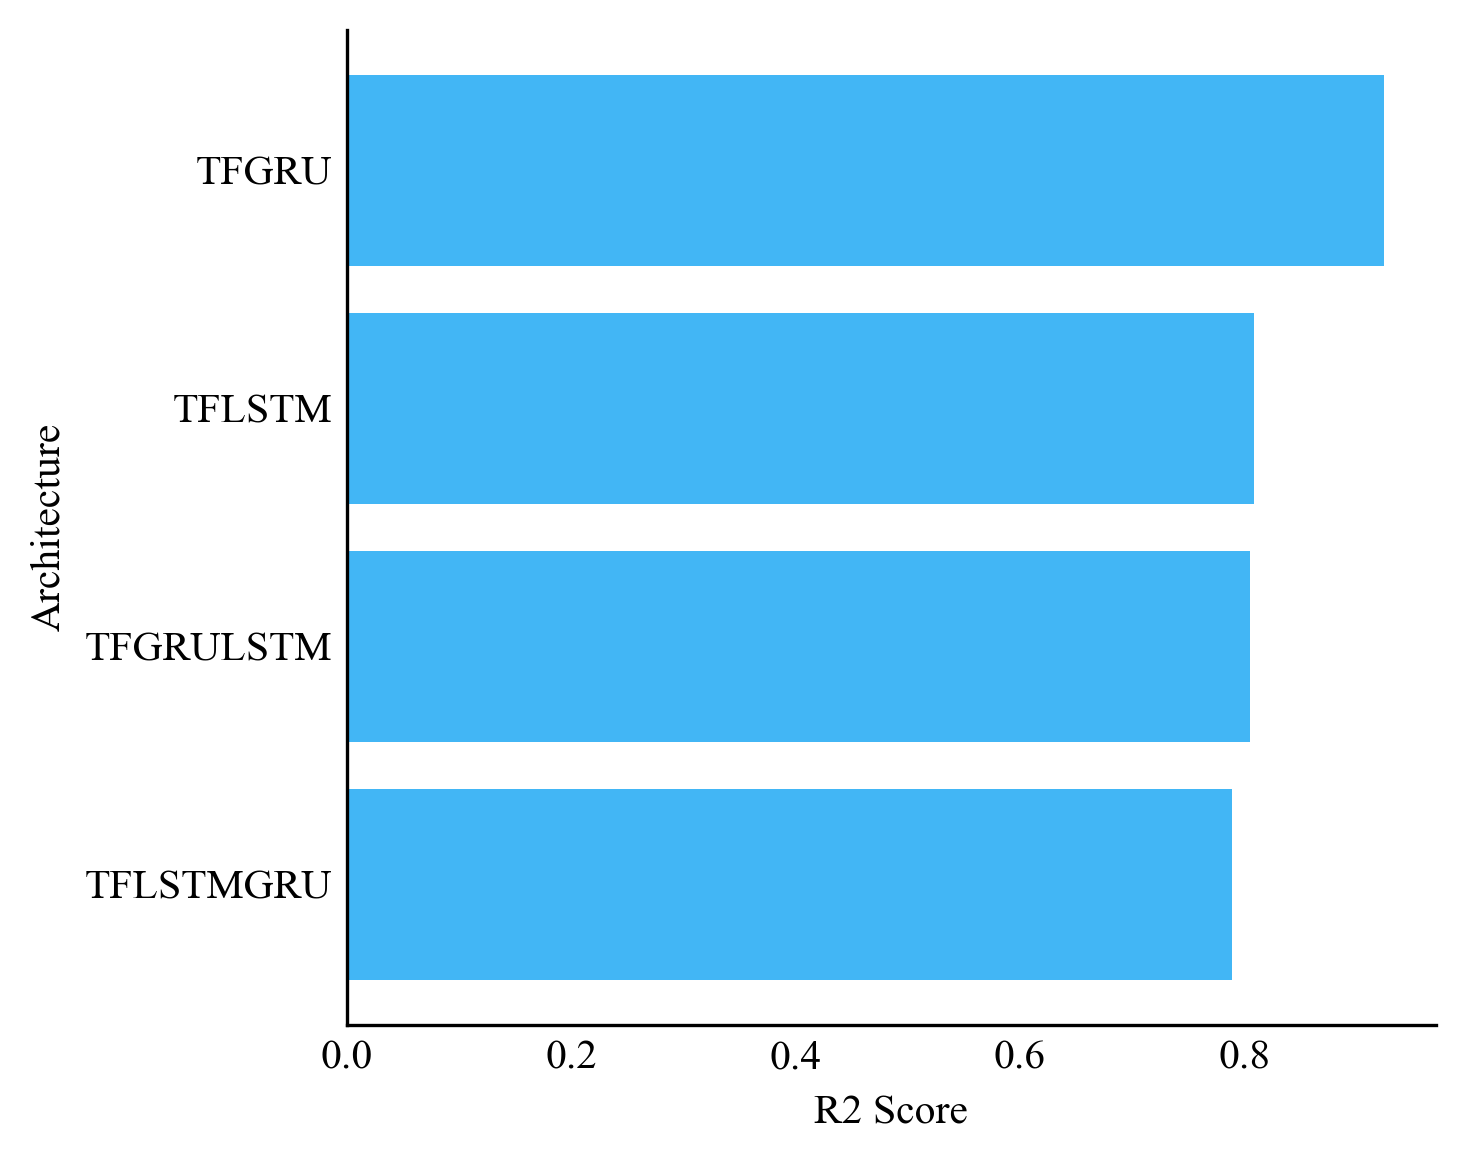

In [662]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('r2', ascending=True)
print(df)
plt.barh(df['arch'], df['r2'], color='#42b6f5')
plt.xlabel('R2 Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

        arch        r2          mse       rmse      mape       acc        f1
3  TFLSTMGRU  0.788476  1848.678099  24.969440  0.093744  0.503283  0.453904
1  TFGRULSTM  0.804831  1700.646970  24.004702  0.091062  0.503944  0.459109
2     TFLSTM  0.808040  1699.309871  23.901767  0.090257  0.502523  0.445102
0      TFGRU  0.924304   634.638006  14.703255  0.056229  0.505766  0.453773


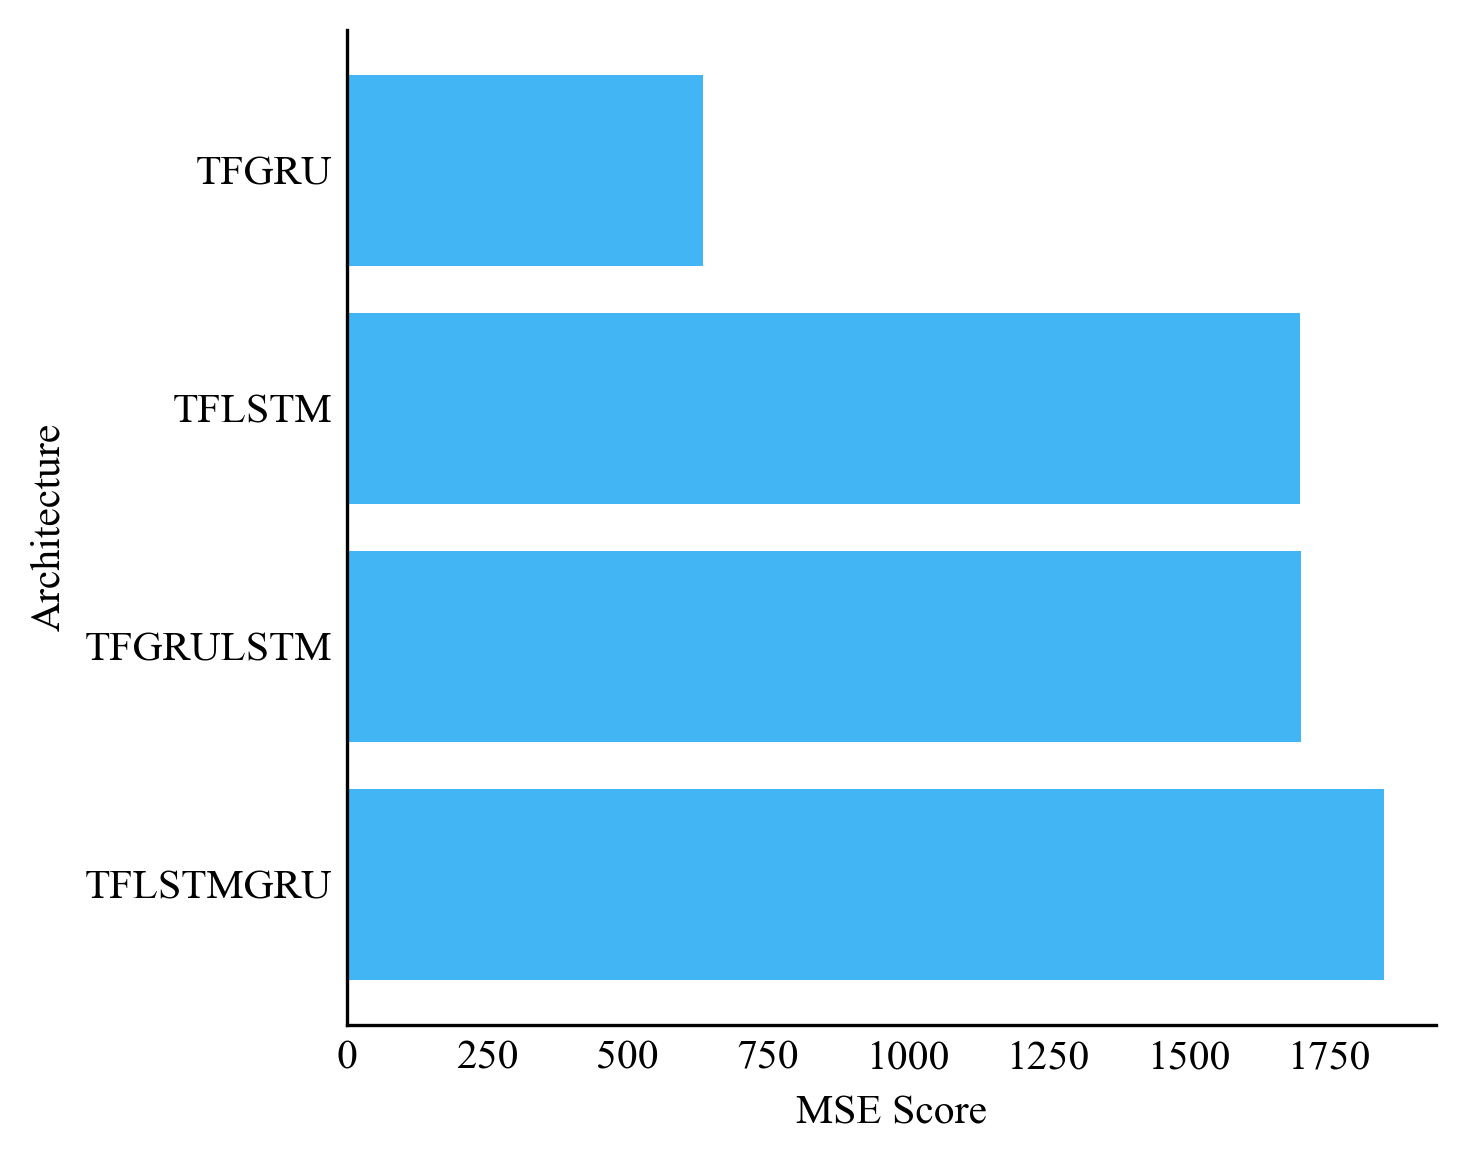

In [663]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('mse', ascending=False)
print(df)
plt.barh(df['arch'], df['mse'], color='#42b6f5')
plt.xlabel('MSE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

        arch        r2          mse       rmse      mape       acc        f1
3  TFLSTMGRU  0.788476  1848.678099  24.969440  0.093744  0.503283  0.453904
1  TFGRULSTM  0.804831  1700.646970  24.004702  0.091062  0.503944  0.459109
2     TFLSTM  0.808040  1699.309871  23.901767  0.090257  0.502523  0.445102
0      TFGRU  0.924304   634.638006  14.703255  0.056229  0.505766  0.453773


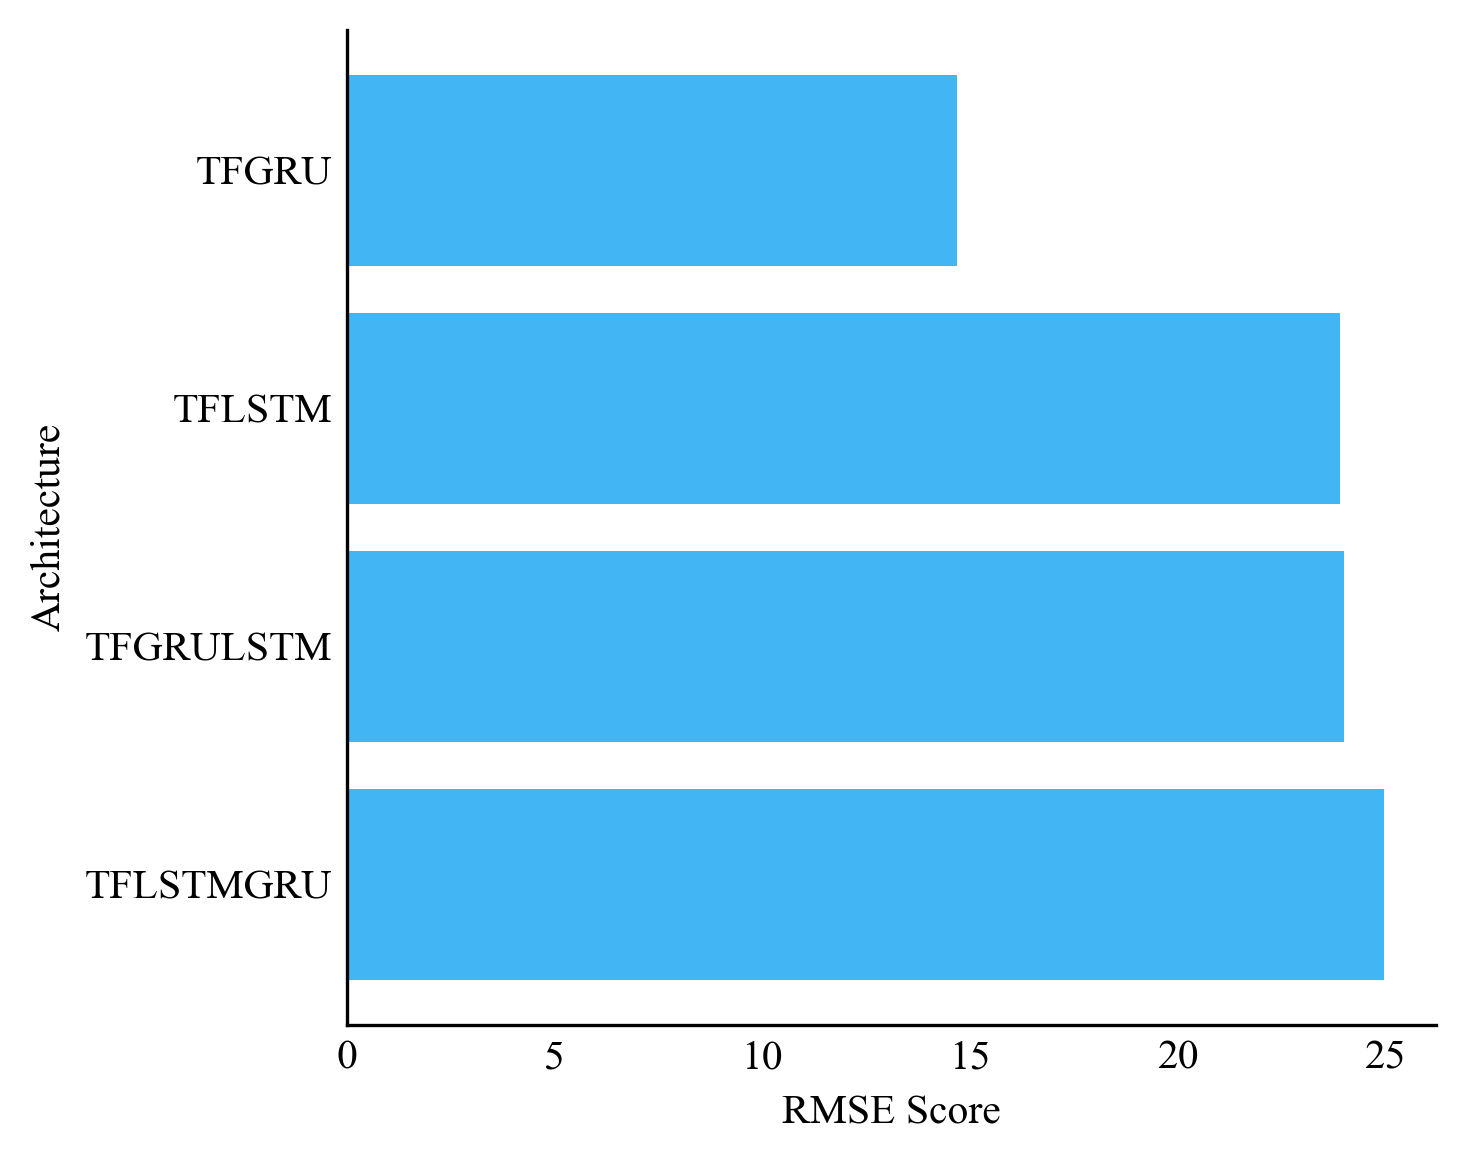

In [664]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('rmse', ascending=False)
print(df)
plt.barh(df['arch'], df['rmse'], color='#42b6f5')
plt.xlabel('RMSE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

        arch        r2          mse       rmse      mape       acc        f1
3  TFLSTMGRU  0.788476  1848.678099  24.969440  0.093744  0.503283  0.453904
1  TFGRULSTM  0.804831  1700.646970  24.004702  0.091062  0.503944  0.459109
2     TFLSTM  0.808040  1699.309871  23.901767  0.090257  0.502523  0.445102
0      TFGRU  0.924304   634.638006  14.703255  0.056229  0.505766  0.453773


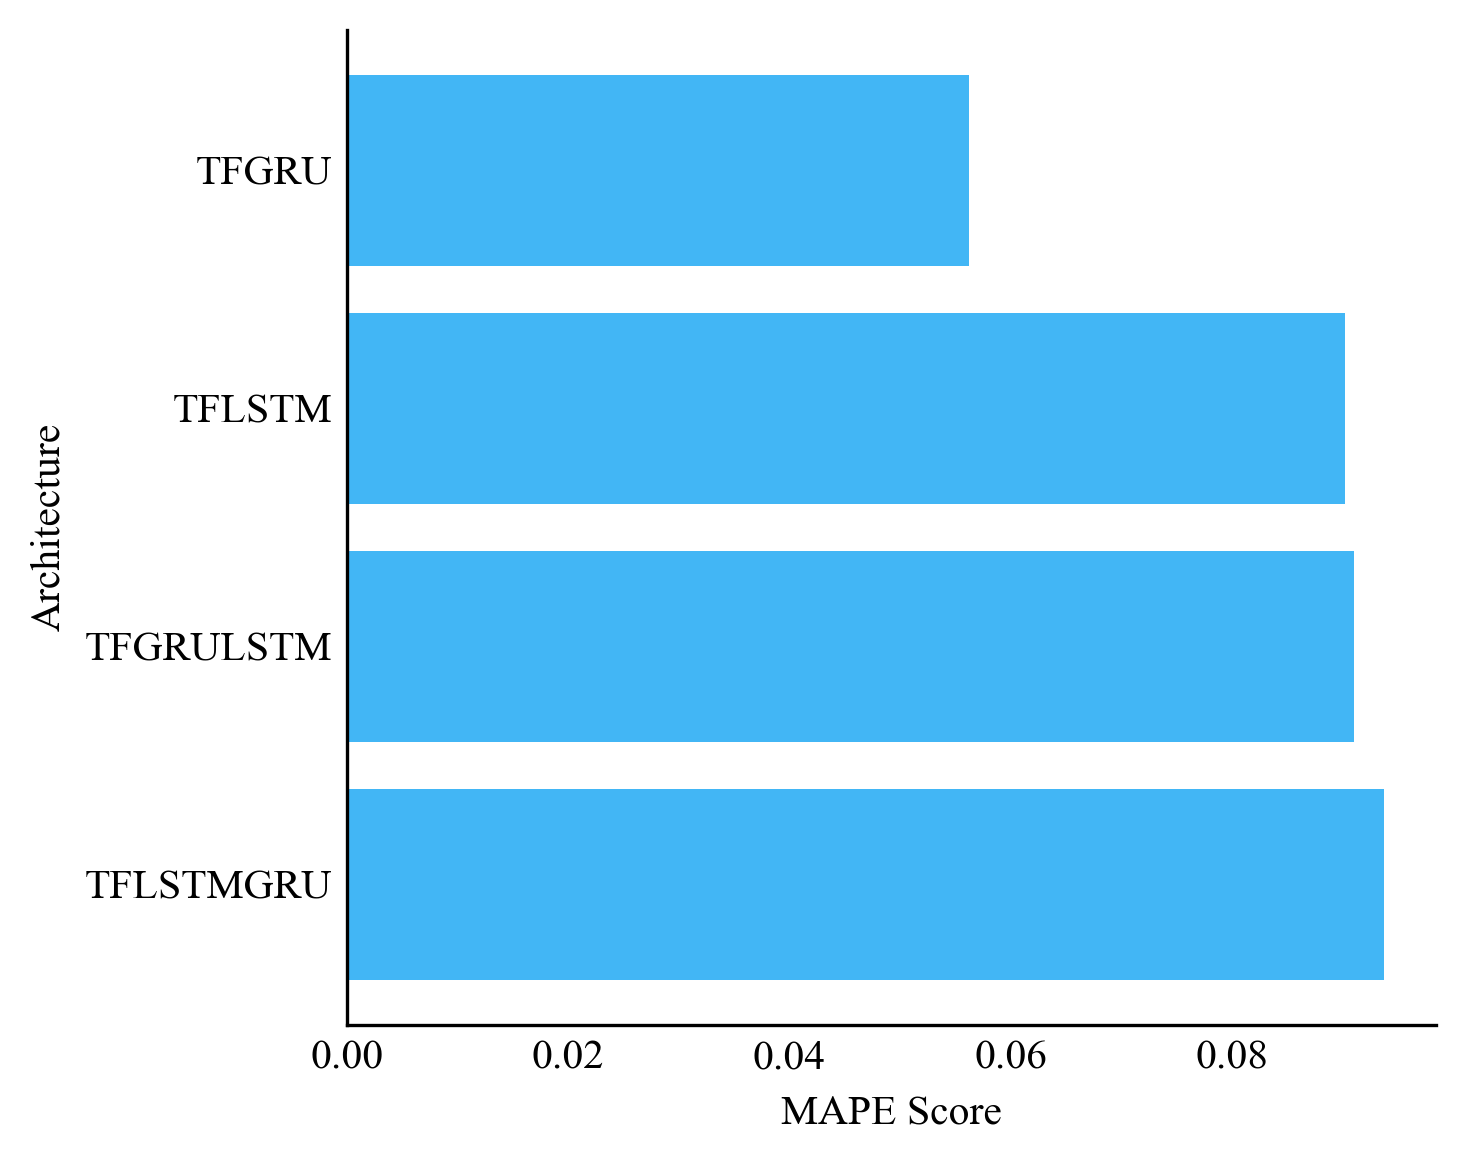

In [665]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('mape', ascending=False)
print(df)
plt.barh(df['arch'], df['mape'], color='#42b6f5')
plt.xlabel('MAPE Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

        arch        r2          mse       rmse      mape       acc        f1
2     TFLSTM  0.808040  1699.309871  23.901767  0.090257  0.502523  0.445102
0      TFGRU  0.924304   634.638006  14.703255  0.056229  0.505766  0.453773
3  TFLSTMGRU  0.788476  1848.678099  24.969440  0.093744  0.503283  0.453904
1  TFGRULSTM  0.804831  1700.646970  24.004702  0.091062  0.503944  0.459109


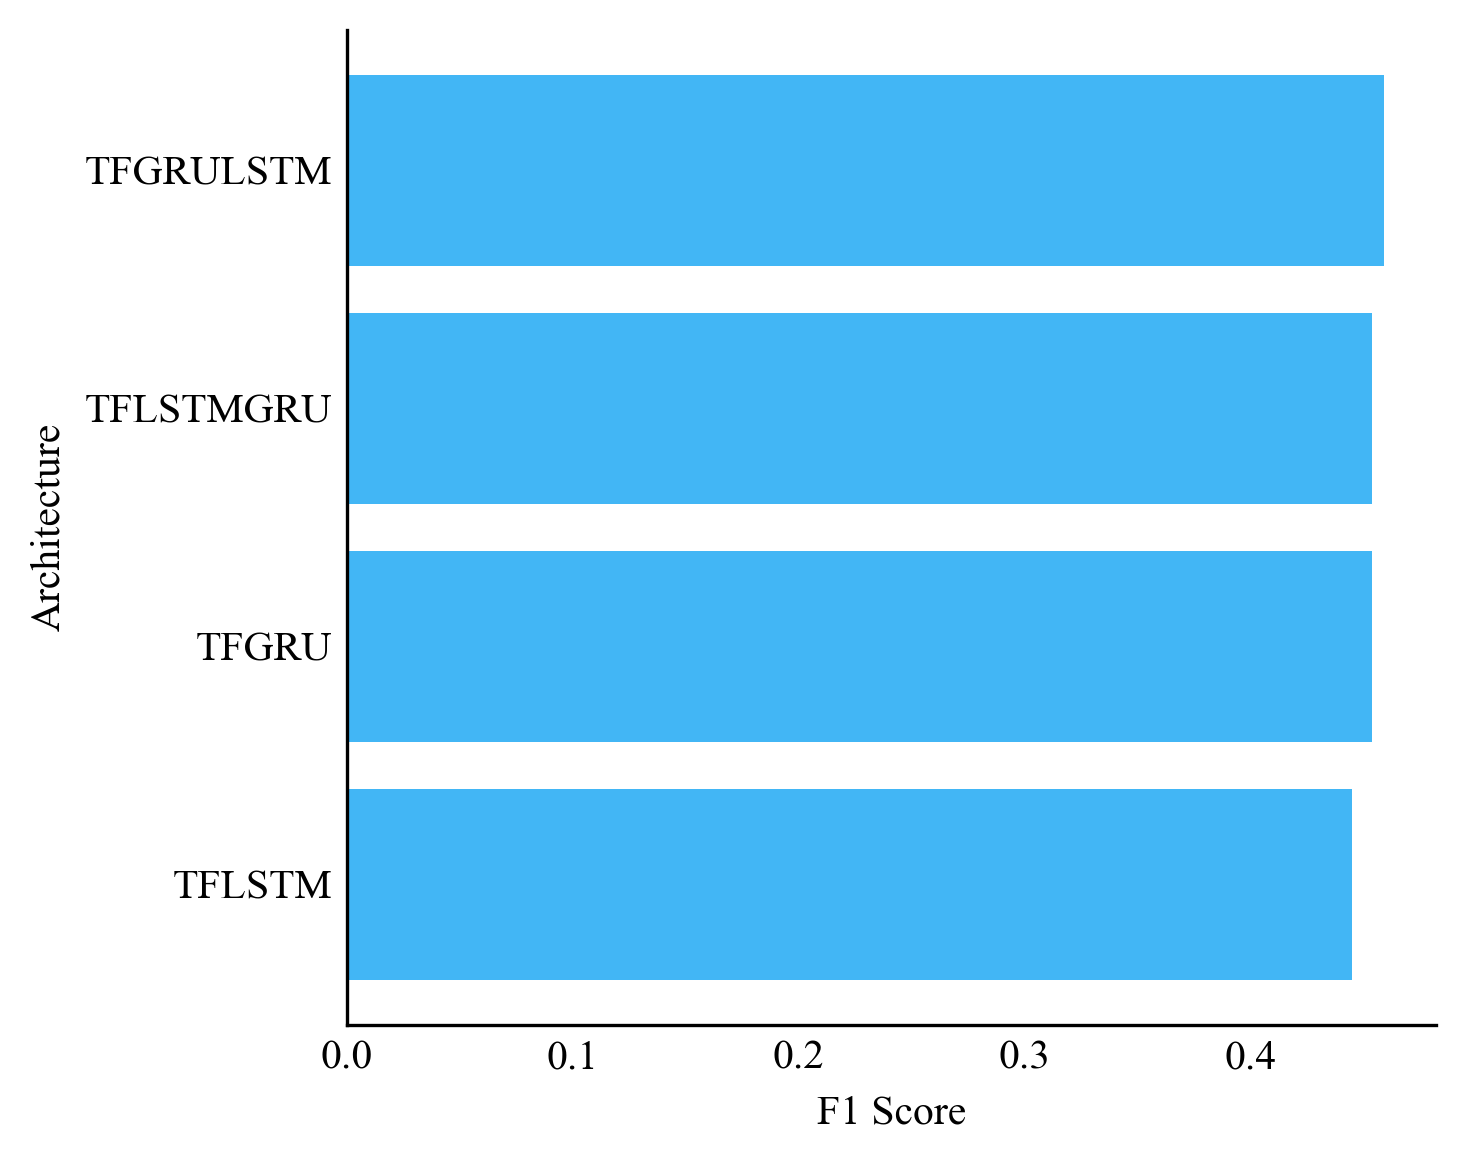

In [666]:
import matplotlib.pyplot as plt
plt.rcdefaults()
plt.rcParams.update({'font.family':'Times New Roman'})
fig = plt.figure(figsize =(5, 4))

df = df_averages_score.sort_values('f1', ascending=True)
print(df)
plt.barh(df['arch'], df['f1'], color='#42b6f5')
plt.xlabel('F1 Score')
plt.ylabel('Architecture')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tick_params(axis='both', which='both', length=0, labelsize=10)
plt.tight_layout()

fig.set_dpi(300.0)
plt.show()

In [667]:
df_result_sort = df_result.sort_values(by=['f1', 'acc', 'mape', 'rmse', 'mse', 'r2'], ascending=[False, False, True, True, True, False])
print(df_result_sort)
# df_result_sort.to_excel('df_result_sort.xlsx', index=False)

     code  lookback       arch        r2          mse       rmse      mape  \
4    AAPL        25      TFGRU  0.992478    11.223702   3.350179  0.019695   
38   MSFT        20  TFLSTMGRU  0.898499   339.904756  18.436506  0.061093   
33   MSFT        20  TFGRULSTM  0.971076    96.860188   9.841757  0.029410   
54   AMZN        25  TFGRULSTM  0.942245    57.883806   7.608141  0.053872   
144  GOOG        25      TFGRU  0.979676    15.750409   3.968678  0.029492   
..    ...       ...        ...       ...          ...        ...       ...   
42   AMZN        15      TFGRU  0.937738    62.400730   7.899413  0.051297   
41   AMZN        10      TFGRU  0.922740    77.431400   8.799511  0.058311   
44   AMZN        25      TFGRU  0.911624    88.572811   9.411313  0.062984   
104  TSLA        25      TFGRU  0.505524  5459.078168  73.885575  0.228042   
160   UNH         5      TFGRU  0.944127   605.895708  24.614949  0.055284   

          acc        f1  
4    0.554555  0.550403  
38   0.5395